In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
#from epifit.transitions import S_I

device = "cuda" if torch.cuda.is_available() else "cpu"

def Population(n:int, device= "cpu"):
  initial_population = { #a columnar DB somewhat reminds the Pandas DataFrame 
      "I":torch.zeros(n).to(device),
      "susceptiveness":torch.ones(n).to(device).requires_grad_(True)*1.0,
      "infectiveness":torch.ones(n).to(device).requires_grad_(True)*1.0
  }
  initial_population["I"][0]=1 #first one infective
  return initial_population

def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter.item()))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')

class SI_dense(torch.nn.Module):
    """
    Stochastic individual base (S)usceptible-(I)nfective transition. 
    The infective agent propagates through an unweighted contact network 
    stored as a dense Tensor.     
    """
    def __init__(self, contact_net, pinf, I_name, susceptiveness_name, infectiveness_name, device, samples=[], start=0):
        super(SI_dense,self).__init__()
        self._contact_net = contact_net
        self._pinf = torch.nn.parameter.Parameter(torch.Tensor([pinf]).to(device)) # set it as trainnable
        self._n = contact_net.size()[0]
        self._t = 0
        self._start = start
        self._states_names = {'I': I_name, 'susceptiveness': susceptiveness_name, 'infectiveness': infectiveness_name}
        self._samples= samples
        
    def forward(self, states):
        self._t+=1
        if self._t >= self._start:
            I = states[self._states_names['I']] # boolean state of being infected
            susceptiveness = states[self._states_names['susceptiveness']] # floating point, number between 0 and 1 means probability of being infected
            infectiveness = states[self._states_names['infectiveness']] # floating point, number between 0 and 1 means probability of infecting another
    
            susceptible = (I==0).float()
            susceptible*=susceptiveness
            susceptible = susceptible.unsqueeze(dim=1)
            infective=infectiveness*I
            infective=infective*self._pinf
            infective = infective.unsqueeze(dim=0)

            con = self._contact_net*infective*susceptible#n*n, 1*n (row multiply), n*1 (column multiply)
            con = torch.log(1 - con)     
            dI = 1 - torch.exp(con.mm(torch.ones(self._n).to(device).unsqueeze(dim=1)).squeeze()) # probability of being infected that day
            #print(dI)
            dIsample= self.get_random_from_samples()
            #random will effect the result, less than operation will lose gradient
            dI_01= dI>dIsample

            dI= dI*(1-I)
            

            I = torch.max(I, dI_01) # got infected

            states[self._states_names['I']] = I

        return states, dI
    def get_random_from_samples(self):
        return self._samples[self._t-1]

In [2]:
def sim(time_horizon, population, model, mode="run"):
  log = [population['I']]
  IMeans = [torch.tensor(0).to(device)]
  for i in range(time_horizon):
    population, dI = model(population)
    log.append(population['I'])
    IMeans.append(dI.sum()+IMeans[-1])
  log = torch.stack(log)
  IMeans = torch.stack(IMeans)
  log = log.unsqueeze(dim=1)
  log = log.unsqueeze(dim=0)
  return log, IMeans

In [3]:
TestCases= [500, 1000, 1500]
TestNumPer= 20
TestResults= {}

for n in TestCases:
    TestResults[n]= []

for n in TestCases:
    for j in range(TestNumPer):
        print(n, " ", j)
        avgDegree = 10  #every individual will have 10 contacts on average
        pinf = 0.2  #it is the first parameter we are going to fit
        time_horizon = 20
        #create  dense contacts
        contacts = generate_random_network(n, avgDegree)
        contacts = contacts.coalesce()#make pairs unique
        contacts = contacts.to_dense()
        contacts = contacts.requires_grad_(True)
        #random to be used
        dIsamples=[]
        for _ in range(time_horizon):
            dIsamples.append(torch.rand(n).to(device))
        #si true 
        si =     SI_dense(contacts, pinf=pinf, I_name="I",susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                        samples=dIsamples, device=device)
        #si fit
        si_fit = SI_dense(contacts, pinf=0.05, I_name="I", susceptiveness_name="susceptiveness",  infectiveness_name="infectiveness", 
                        samples=dIsamples, device=device)
        #deinfe loss function
        loss_fn = torch.nn.MSELoss(reduction='sum')
        optimizer = torch.optim.Adam(si_fit.parameters(), lr=5e-3)
        #generate real data
        si_result= None
        with torch.no_grad():
            population = Population(n, device=device)
            si_result, _ = sim(time_horizon, population, si, mode="run")
        #dIs_result= dIs_result.sum(dim=1)
        stats_gt   = si_result.sum(dim=3) # si along 20 iterations
        stats_gt   = stats_gt.squeeze()
        stats_gt.requires_grad_(True)
        colors = [("red", 'I')]
        age_sizes = [n]
        for i in range(250):
            optimizer.zero_grad()
            si_fit._t=0
            population = Population(n, device=device)
            si_pred, IMeans_pred = sim(time_horizon, population, si_fit, mode="train")
            loss = loss_fn(stats_gt, IMeans_pred)
            loss.backward(retain_graph=True)
            optimizer.step()
        print(si_fit._pinf.item())
        TestResults[n].append(si_fit._pinf.item())
        torch.cuda.empty_cache()


200   0
0.17310336232185364
200   1
0.1474604457616806
200   2
0.1943921148777008
200   3
0.15120157599449158
200   4
0.20321400463581085
200   5
0.1744530200958252
200   6
0.19843776524066925
200   7
0.2591378390789032
200   8
0.22200535237789154
200   9
0.17694592475891113
200   10
0.23506136238574982
200   11
0.32597842812538147
200   12
0.2810039818286896
200   13
0.2135574221611023
200   14
0.17119529843330383
200   15
0.2021673619747162
200   16
0.15956763923168182
200   17
0.2642039358615875
200   18
0.25167807936668396
200   19
0.1685463786125183
200   20
0.17277127504348755
200   21
0.15705208480358124
200   22
0.12619516253471375
200   23
0.237590491771698
200   24
0.17764247953891754
200   25
0.24884240329265594
200   26
0.2041812539100647
200   27
0.22135323286056519
200   28
0.18946008384227753
200   29
0.17420218884944916
500   0
0.22197014093399048
500   1
0.1945837140083313
500   2
0.23257149755954742
500   3
0.1825534552335739
500   4
0.18557824194431305
500   5
0.1522

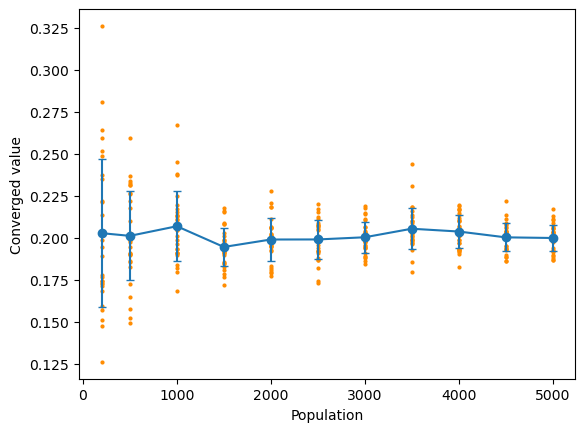

[0.20275339831908543, 0.20114898631970088, 0.20687588006258012, 0.19454932063817978, 0.1989778478940328, 0.19901729623476663, 0.20031056503454844, 0.20538851767778396, 0.2037354658047358, 0.20027028967936833, 0.19988686243693035]
[0.04416853412005803, 0.026471446562741047, 0.020699514719751604, 0.011418637944300824, 0.012525859013687406, 0.01156408755818864, 0.00919702875679052, 0.012139075907360146, 0.009951269790156727, 0.00837604374803768, 0.007992392511304713]


In [35]:
import numpy as np
x=[]
y=[]
xs=[]
means= []
stds= []
for n in TestCases:
    vector= np.array(TestResults[n])
    xs.append(n)
    means.append(np.mean(vector))
    stds.append(np.sqrt(np.var(vector)))
    for m in TestResults[n]:
        x.append(n)
        y.append(m)
plt.scatter(x, y, c="darkorange", s= 4)
plt.errorbar(xs, means, stds, marker='o', capsize=3)
plt.xlabel("Population")
plt.ylabel("Converged value")
plt.show()
print(means)
print(vars)


[200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500, 3500]
[0.2961840033531189, 0.23963648080825806, 0.13494639098644257, 0.28609097003936